# Zeroth-order Frank-Wolfe Variants for Matrix Completion

## Project for Optimization for Data Science 2021-2022 course

Matteo Bergamaschi, Simone De Renzis, Andrea Marchini, Luca Veronese

In [ ]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.sparse.linalg import svds as svds

np.random.seed(1337)
import time
from sklearn.preprocessing import MinMaxScaler

# Utility functions

## Plotting functions

In [ ]:
# utils function to plot stuff

from IPython.display import display, HTML
import pandas as pd

def print_np(numpy_data,n_rows=5):
  df = pd.DataFrame(data=numpy_data)
  display(HTML(df.head(n_rows).to_html()))

def convergence_plot(fs):
    plt.figure(figsize=(14,6))
    plt.title('Convergence in objective')
    plt.xlabel('Step')
    plt.ylabel('Error')
    # plt.yscale('log')
    plt.plot(range(len(fs)), fs)


def plot_matrix(X):
  fig = plt.figure(figsize=(8,6))
  scaler = MinMaxScaler()
  scaler.fit(X)
  plt.imshow(scaler.transform(X))
  plt.colorbar()
  plt.show()

## Nuclear norm

In [ ]:
def nuclear_norm(A):
    return np.linalg.norm(A,ord="nuc")

# Movielens100k dataset

In [ ]:
from urllib.request import urlretrieve
import zipfile
import pandas as pd

urlretrieve("http://files.grouplens.org/datasets/movielens/ml-100k.zip", "movielens.zip")
zip_ref = zipfile.ZipFile('movielens.zip', "r")
zip_ref.extractall()

ratings_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
data1 = pd.read_csv('ml-100k/u.data',sep='\t', names=ratings_cols, encoding='latin-1')
data2 = pd.pivot_table(data1, columns='user_id', index='movie_id', values='rating').reset_index()
data2.drop('movie_id', axis=1, inplace=True)
movie_data = data2.to_numpy(na_value=0)
movie_data = movie_data.T
n0, n1 = movie_data.shape

A = movie_data # A holds the original matrix
O = np.array((A != 0),float) # O is a binary mask for the observed values
fA = np.linalg.norm(A, 'fro') # frobenius norm of A
Y = A / fA # We scale the matrix for its frobenius norm, and put the result in Y

The shape of the starting matrix.

In [ ]:
Y.shape

(943, 1682)

The nuclear norm of the starting matrix.

In [ ]:
nuclear_norm(Y)

18.757626953198834

We visualize the starting matrix. Note that, in order to provide a better visualization, in this and in the following matrix plots the values are scaled into a $[0,1]$ range with a min max scaler.

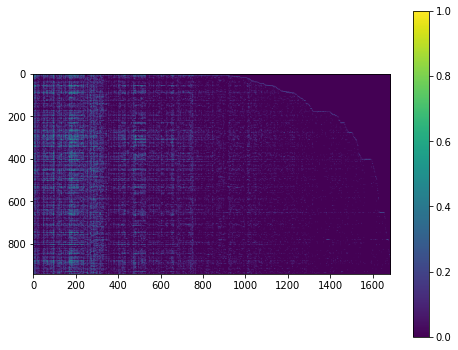

In [ ]:
plot_matrix(A)

# Convex case: Frobenius norm objective function

This is not the main point of our work, but we found it useful to provide also a small study for the convex case.

Objective function based on *Frobenius norm*.



In [ ]:
def objective_function(Y, O, X):
    """Matrix completion objective."""
    return 0.5 * np.linalg.norm(Y - X * O, 'fro')**2

F = lambda X: objective_function(Y, O, X)

The subproblem for the matrix completion problem.

In [ ]:
def subproblem(X, delta):
    x, _, y = svds(-X, k=1, which = "LM")
    return delta * x @ y

## FOFW (First Order Frank-Wolfe)

This is the first-order Frank-Wolfe, used as a benchmark to compare to zeroth-orders methods.

In [ ]:
def FOFW_gradient(Y, O, X):
  return X * O - Y


def FOFW_oracle_call(Y, O, X, delta):
    """Linear optimization oracle for matrix completion."""
    G = FOFW_gradient(Y, O, X)
    x, _, y = svds(-G, k=1, which = "LM")
    return delta * x @ y


def FOFW(Y, O, constr):
  """
  First Order FW

  - Y: starting matrix
  - O: binary mask of observed values
  - constr: numerical value for the constraint on the nuclear norm
  """
  d0, d1 = Y.shape
  X0 = np.random.normal(0,1, (n0,n1)) # random initialization
  X0 = subproblem(X0,constr) # bring the initial iterate into the feasible set
  xs = [X0] # list that accumulates iterates

  for t in range(1, 100):
    stepsize = 1/(t+5)
    oracle = FOFW_oracle_call(Y, O, xs[-1], constr) # oracle call
    x = xs[-1] + stepsize * (oracle - xs[-1])
    xs.append(x)
  return xs

In [ ]:
start_time = time.time()

Xs_FOFW = FOFW(Y, O, constr=5)
time_FOFW = time.time() - start_time
print("--- %s seconds ---" % (time_FOFW))

--- 8.205061912536621 seconds ---


The nuclear norm of the resulting matrix.

In [ ]:
nuclear_norm(Xs_FOFW[-1])

3.7772895916498292

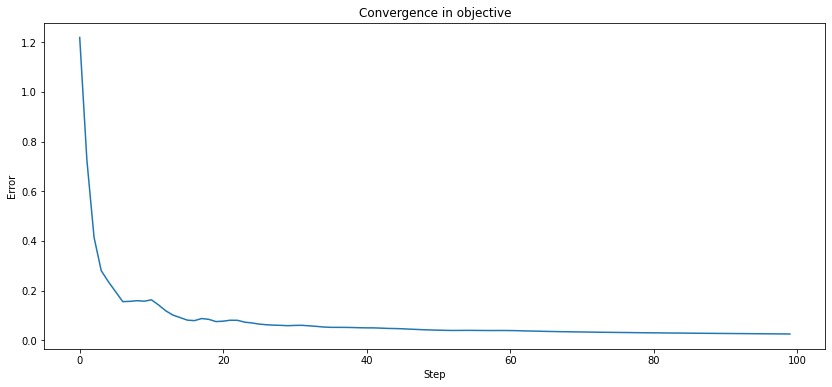

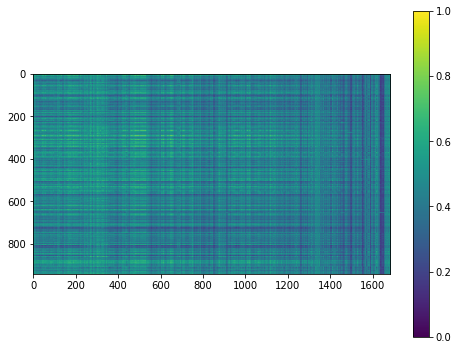

In [ ]:
convergence_plot([objective_function(Y, O, X) for X in Xs_FOFW])
plot_matrix(Xs_FOFW[-1])

## SGFFW (Stochastic Gradient Free FW)

From (SAHU et al. 2019)

### Deterministic Zeroth-order FW

$$g(x_t)=\sum_{i=1}^d \frac{F(x_t + c_t e_i) - F(x_t)}{c_t}e_i$$

We can perform the following optimization to speed up the execution:

$H = X + c_t E_{i,j}$

$F(H) = frob(H-Y) = \frac{1}{2}\sum_{a,b}|h_{a,b}-y_{a,b}|^2$

$F(H)-F(X) = \frac{1}{2}\sum_{a,b}|h_{a,b}-y_{a,b}|^2 - \frac{1}{2}\sum_{a,b}|x_{a,b}-y_{a,b}|^2$

$F(H)-F(X) = \frac{1}{2}|h_{i,j}-y_{i,j}|^2 - \frac{1}{2}|x_{i,j}-y_{i,j}|^2$

$= \frac{1}{2}(|x_{i,j}+c_t-y_{i,j}|^2 - |x_{i,j}-y_{i,j}|^2)$

$= c_t \cdot (\frac{1}{2} c_t + x_{ij} - y_{ij})$

Thus

$\frac{F(H)-F(X)}{c_t} = \frac{1}{2} c_t + x_{ij} - y_{ij}$






In [ ]:
def DZFW_gradient(Y, O, X, stepsize):
  d0, d1 = Y.shape
  L = 0.1
  c_t = (L * stepsize)/(d0*d1)
  grad = 0.5 * c_t * O + X * O - Y # optimized version
  return grad

def DZFW_oracle_call(Y, O, X, delta, stepsize):
    G = DZFW_gradient(Y, O, X, stepsize)
    x, _, y = svds(-G, k=1, which = "LM", maxiter=10)
    return delta * x @ y


def DZFW(Y, O, constr):
  """
  Deterministic Zeroth-order FW

  - Y: starting matrix
  - O: binary mask of observed values
  - constr: numerical value for the constraint on the nuclear norm
  """

  d0, d1 = Y.shape
  X0 = np.random.normal(0,1, (d0,d1)) # random initialization
  X0 = subproblem(X0,constr) # bring the initial iterate into the feasible set
  xs = [X0] # list that accumulates iterates

  for t in range(1, 100):
    stepsize = 1/(t+5)
    oracle = DZFW_oracle_call(Y, O, xs[-1], constr, stepsize) # oracle call
    x = (1 - stepsize) * xs[-1] + stepsize * (oracle - xs[-1])
    xs.append(x)
  return xs

Let's run it.

In [ ]:
start_time = time.time()

Xs_DZFW = DZFW(Y, O, constr=5)

time_DZFW = time.time() - start_time
print("--- %s seconds ---" % (time_DZFW))

--- 9.013230323791504 seconds ---


The nuclear norm of the resulting matrix.

In [ ]:
nuclear_norm(Xs_DZFW[-1])

2.454225214272497

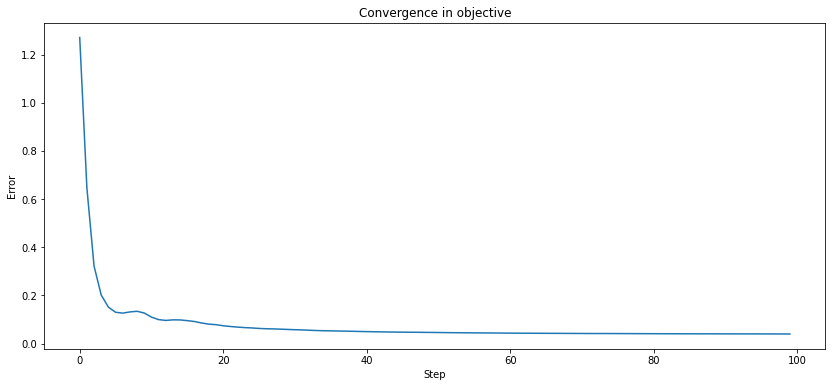

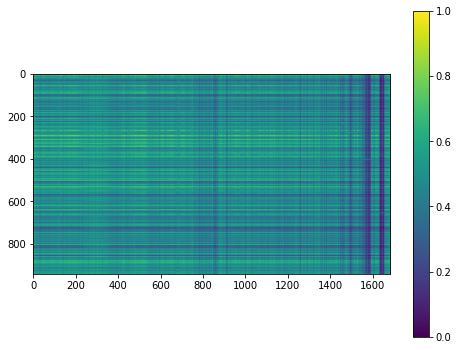

In [ ]:
convergence_plot([objective_function(Y, O, X) for X in Xs_DZFW])
plot_matrix(Xs_DZFW[-1])

### SGFFW -- KWSA (Kiefer Volfowitz Stochastic Approximation)

$$g(x_t;y)=\sum_{i=1}^d \frac{F(x_t + c_t e_i;y) - F(x_t;y)}{c_t}e_i$$

In [ ]:
def SGFFW_KWSA_gradient(Y, O, X, t, stepsize):
  d0, d1 = Y.shape
  c_t = 2 / ((d0*d1)**(1/2) * (t+8)**(1/3))
  grad = 0.5 * c_t * O + X * O - Y
  return grad


def SGFFW_KWSA_oracle_call(Y, O, X, delta, t, stepsize, d_prev):
    G = SGFFW_KWSA_gradient(Y, O, X, t, stepsize)
    p_t = 4 / ((t+8)**(2/3))
    d_t = (1 - p_t)*d_prev + p_t*G
    x, _, y = svds(-d_t, k=1, which = "LM", maxiter=10)
    return [delta * x @ y, d_t]


def SGFFW_KWSA(Y, O, constr):
  """
  SGFFW - Kiefer Volfowitz Stochastic Approximation

  - Y: starting matrix
  - O: binary mask of observed values
  - constr: numerical value for the constraint on the nuclear norm
  """
  d0, d1 = Y.shape
  X0 = np.random.normal(0,1, (n0,n1)) # random initialization
  X0 = subproblem(X0,constr) # bring the initial iterate into the feasible set
  xs = [X0] # list that accumulates iterates
  ds = [0]
  for t in range(1, 100):
    stepsize = 2./(t+8.)
    oracle = SGFFW_KWSA_oracle_call(Y, O, xs[-1], constr, t, stepsize, ds[-1]) # oracle call
    x = (1 - stepsize) * xs[-1] + stepsize * (oracle[0] - xs[-1])
    ds.append(oracle[1])
    xs.append(x)
  return xs


Let's run it.

In [ ]:
start_time = time.time()

Xs_SGFFW_KWSA = SGFFW_KWSA(Y, O, constr=5)

time_SGFFW_KWSA = time.time() - start_time
print("--- %s seconds ---" % (time_SGFFW_KWSA))

--- 10.880910873413086 seconds ---


The nuclear norm of the resulting matrix.

In [ ]:
nuclear_norm(Xs_SGFFW_KWSA[-1])

2.4529319124544933

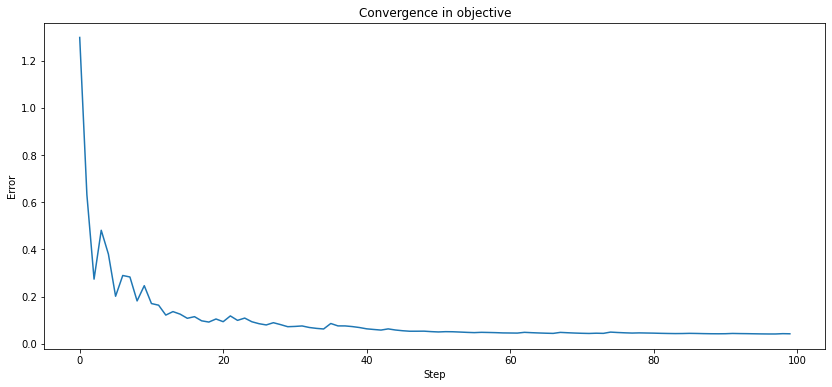

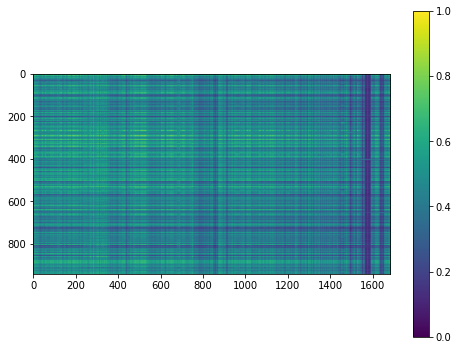

In [ ]:
convergence_plot([objective_function(Y, O, X) for X in Xs_SGFFW_KWSA])
plot_matrix(Xs_SGFFW_KWSA[-1])

### SGFFW -- RDSA (Random Direction Stochastic Approximation)

$$g(x_t;y;z_t)=\frac{F(x_t + c_t z_t;y) - F(x_t;y)}{c_t}z_t$$

with $$z_t \sim  N(0,I_d)$$

In [ ]:
def SGFFW_RDSA_gradient(Y, O, X, t, stepsize):
  d0, d1 = Y.shape
  c_t = 2 / (((d0*d1)**(3/2)) * ((t+8)**(1/3)))
  z = np.random.normal(0,1,(d0,d1))
  grad = ((F(X + c_t * z) - F(X)) / c_t) * z * O
  return grad


def SGFFW_RDSA_oracle_call(Y, O, X, delta, t, stepsize, d_prev):
    G = SGFFW_RDSA_gradient(Y, O, X, t, stepsize)
    d0, d1 = Y.shape
    p_t = 4 / ((t+8)**(2/3))
    d_t = (1 - p_t)*d_prev + p_t*(G)
    x, _, y = svds(-d_t, k=1, which = "LM")
    return [delta * x @ y, d_t]


def SGFFW_RDSA(Y, O, constr):
  """
  SGFFW - Random Direction Stochastic Approximation

  - Y: starting matrix
  - O: binary mask of observed values
  - constr: numerical value for the constraint on the nuclear norm
  """
  d0, d1 = Y.shape
  X0 = np.random.normal(0,1, (n0,n1)) # random initialization
  X0 = subproblem(X0,constr) # bring the initial iterate into the feasible set
  xs = [X0] # list that accumulates iterates
  ds = [0]

  for t in range(1, 100):
    stepsize = 1/(t+8)
    oracle = SGFFW_RDSA_oracle_call(Y, O, xs[-1], constr, t, stepsize, ds[-1]) # oracle call
    x = (1 - stepsize) * xs[-1] + stepsize * (oracle[0] - xs[-1])
    ds.append(oracle[1])
    xs.append(x)
  return xs

Let's run it.

In [ ]:
start_time = time.time()

Xs_SGFFW_RDSA = SGFFW_RDSA(Y, O, constr=5)
time_SGFFW_RDSA = time.time() - start_time
print("--- %s seconds ---" % (time_SGFFW_RDSA))

--- 26.61797523498535 seconds ---


The nuclear norm of the resulting matrix.

In [ ]:
nuclear_norm(Xs_SGFFW_RDSA[-1])

2.1723583988556827

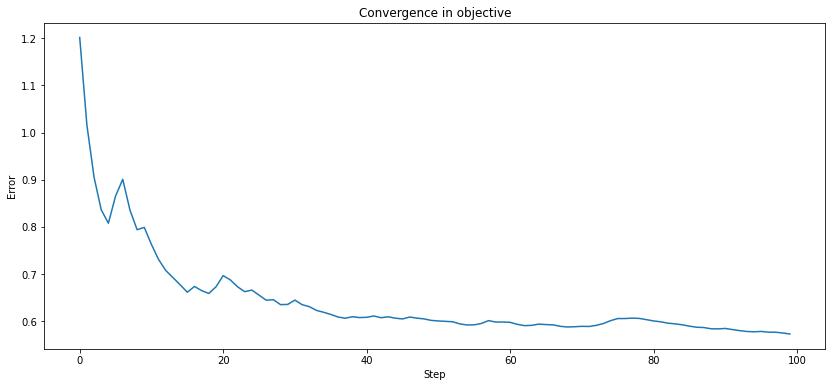

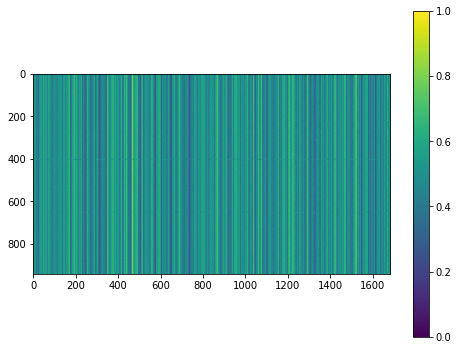

In [ ]:
convergence_plot([objective_function(Y, O, X) for X in Xs_SGFFW_RDSA])
plot_matrix(Xs_SGFFW_RDSA[-1])

### SGFFW -- I-RDSA (Improvized Random Direction Stochastic Approximation)

$$g(x_t;y;z_t)=\frac{1}{m} \sum_{i=1}^m\frac{F(x_t + c_t z_{i,t};y) - F(x_t;y)}{c_t}z_{i,t}$$

with $$\{z_{i,t}\}_{i=1}^m \sim  N(0,I_d)$$

In [ ]:
def SGFFW_IRDSA_gradient(Y, O, X, t, stepsize, m):
  d0,d1 = Y.shape
  c_t = (2 * m**(1/2)) / ((d0*d1)**(3/2)*(t+8)**(1/3))
  grad = np.zeros((d0,d1))
  for i in range(m):
    z_i = np.random.normal(0,1,(d0,d1))
    grad += (F(X + c_t * z_i) - F(X)) * z_i / c_t * O
  return 1/m * grad


def SGFFW_IRDSA_oracle_call(Y, O, X, delta, t, stepsize, d_prev, m):
    G = SGFFW_IRDSA_gradient(Y, O, X, t, stepsize, m)
    d0,d1 = Y.shape
    p_t = 4 / ((1+(d0*d1)/m)**(1/3) * (t+8)**(2/3))
    d_t = (1 - p_t)*d_prev + p_t*G
    x, _, y = svds(-d_t, k=1, which = "LM")
    return [delta * x @ y, d_t]


def SGFFW_IRDSA(Y, O, constr, m):
  """
  SGFFW - Improvized Random Direction Stochastic Approximation

  - Y: starting matrix
  - O: binary mask of observed values
  - constr: numerical value for the constraint on the nuclear norm
  """
  d0,d1 = Y.shape
  X0 = np.random.normal(0,1, (n0,n1)) # random initialization
  X0 = subproblem(X0,constr) # bring the initial iterate into the feasible set
  xs = [X0] # list that accumulates iterates
  ds = [0]
  for t in range(0, 100):
    stepsize = 2./(t+8.)
    oracle = SGFFW_IRDSA_oracle_call(Y, O, xs[-1], constr, t, stepsize, ds[t], m) # oracle call
    x = (1 - stepsize) * xs[-1] + stepsize * (oracle[0] - xs[-1])
    ds.append(oracle[1])
    xs.append(x)
  return xs

Let's run it.

In [ ]:
start_time = time.time()
Xs_SGFFW_IRDSA = SGFFW_IRDSA(Y, O, constr=5, m=20)

time_SGFFW_IRDSA = time.time() - start_time

print("--- %s seconds ---" % (time_SGFFW_IRDSA))

--- 280.9661087989807 seconds ---


The nuclear norm of the resulting matrix.

In [ ]:
nuclear_norm(Xs_SGFFW_IRDSA[-1])

2.499110921878696

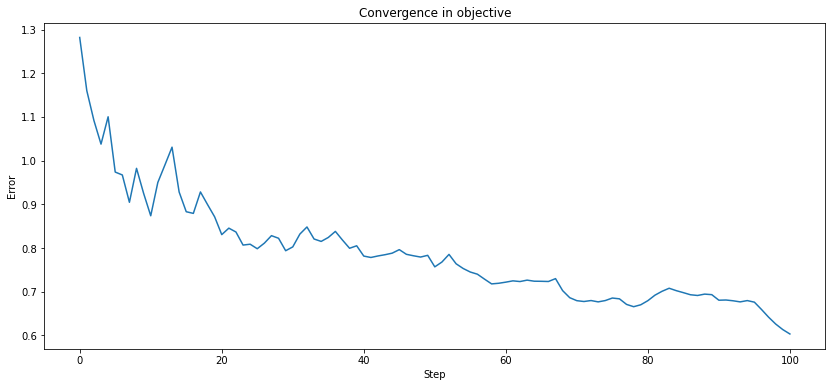

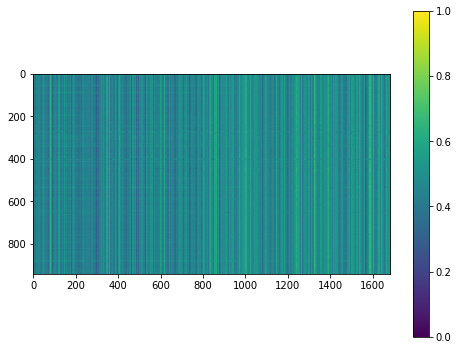

In [ ]:
convergence_plot([objective_function(Y, O, X) for X in Xs_SGFFW_IRDSA])
plot_matrix(Xs_SGFFW_IRDSA[-1])

## Comparing results - Convex case

In [ ]:
fs_FOFW = [objective_function(Y, O, X) for X in Xs_FOFW]
fs_DZFW = [objective_function(Y, O, X) for X in Xs_DZFW]
fs_SGFFW_KWSA = [objective_function(Y, O, X) for X in Xs_SGFFW_KWSA]
fs_SGFFW_RDSA = [objective_function(Y, O, X) for X in Xs_SGFFW_RDSA]
fs_SGFFW_IRDSA = [objective_function(Y, O, X) for X in Xs_SGFFW_IRDSA]

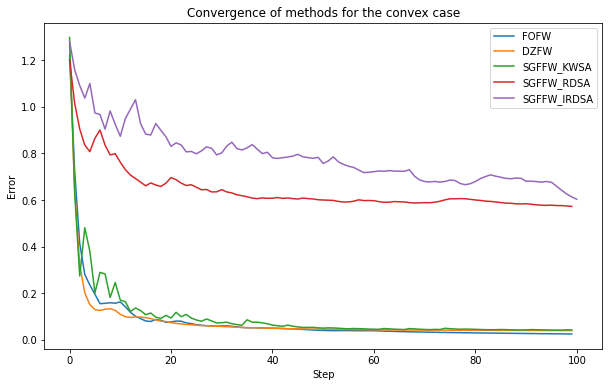

In [ ]:
plt.figure(figsize=(10,6))
plt.title('Convergence of methods for the convex case')
plt.xlabel('Step')
plt.ylabel('Error')
# plt.yscale('log')
plt.plot(range(len(fs_FOFW)), fs_FOFW, label = "FOFW")
plt.plot(range(len(fs_DZFW)), fs_DZFW, label = "DZFW")
plt.plot(range(len(fs_SGFFW_KWSA)), fs_SGFFW_KWSA, label = "SGFFW_KWSA")
plt.plot(range(len(fs_SGFFW_RDSA)), fs_SGFFW_RDSA, label = "SGFFW_RDSA")
plt.plot(range(len(fs_SGFFW_IRDSA)), fs_SGFFW_IRDSA, label = "SGFFW_IRDSA")
plt.legend()

# Non convex case: robust objective function

## SGFFW -- I-RDSA Non Convex

The non convex case uses the loss function defined in (GAO and HUANG, 2020) to solve the problem of robust low-rank matrix completion.

In [ ]:
F = lambda X: objective_function_robust(Y, O, X)

def objective_function_robust(Y, O, X):
    """Matrix completion objective."""
    sigma = 10
    return np.sum((1 - np.exp((-(X * O - Y)**2)/sigma**2)))

In [ ]:
def SGFFW_IRDSA_NC_gradient(Y, O, X, t, stepsize, m):
  d0,d1 = Y.shape
  c_t = (2 * m**(1/2)) / ((d0*d1)**(3/2)*(t+8)**(1/3))
  grad = np.zeros((d0,d1))
  for i in range(m):
    z_i = np.random.normal(0,1,(d0,d1))
    grad += (F(X + c_t * z_i) - F(X)) * z_i / c_t
  return 1/m * grad


def SGFFW_IRDSA_NC_oracle_call(Y, O, X, constr, t, stepsize, d_prev, m):
    G = SGFFW_IRDSA_NC_gradient(Y, O, X, t, stepsize, m)
    d0,d1 = Y.shape
    p_t = 4 / ((1+(d0*d1)/m)**(1/3) * (t+8)**(2/3))
    d_t = (1 - p_t)*d_prev + p_t*G
    x, _, y = svds(-d_t, k=1, which = "LM")
    return [constr * x @ y, d_t]


def SGFFW_IRDSA_NC(Y, O, constr, m, numiter=50):
  """
  SGFFW - Improvized Random Direction Stochastic Approximation (Non Convex)

  - Y: starting matrix
  - O: binary mask of observed values
  - constr: numerical value for the constraint on the nuclear norm
  """
  d0,d1 = Y.shape
  X0 = np.random.normal(0,1, (n0,n1)) # random initialization
  X0 = subproblem(X0,constr) # bring the initial iterate into the feasible set
  xs = [X0] # list that accumulates iterates
  ds = [0]
  for t in range(0, numiter):
    stepsize = 1/(numiter**(3/4))
    oracle = SGFFW_IRDSA_NC_oracle_call(Y, O, xs[-1], constr, t, stepsize, ds[t], m) # oracle call
    x = (1 - stepsize) * xs[-1] + stepsize * (oracle[0] - xs[-1])
    ds.append(oracle[1])
    xs.append(x)
  return xs

Let's run it.

In [ ]:
start_time = time.time()

Xs_SGFFW_IRDSA_NC = SGFFW_IRDSA_NC(Y, O, constr=5, m=50, numiter=100)

time_SGFFW_IRDSA_NC = time.time() - start_time
print("--- %s seconds ---" % (time_SGFFW_IRDSA_NC))

--- 507.8891866207123 seconds ---


The nuclear norm of the resulting matrix.

In [ ]:
nuclear_norm(Xs_SGFFW_IRDSA_NC[-1])

2.503358296416237

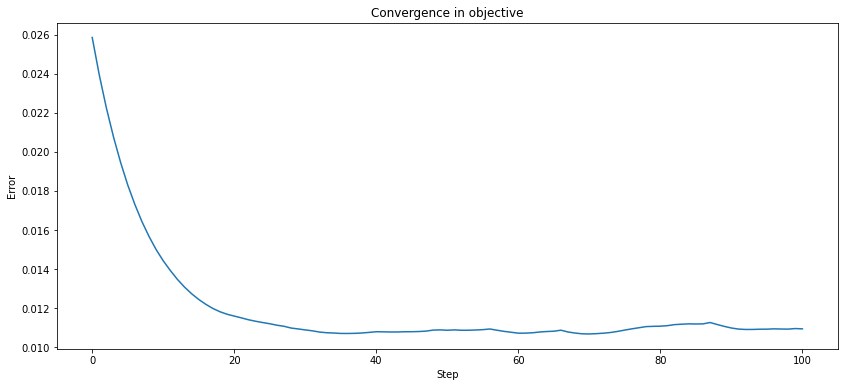

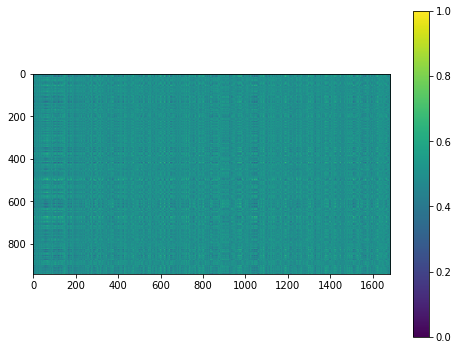

In [ ]:
convergence_plot([objective_function_robust(Y, O, X) for X in Xs_SGFFW_IRDSA_NC])
plot_matrix(Xs_SGFFW_IRDSA_NC[-1])






## FZFW (Faster Zeroth-order FW)

From (GAO and HUANG, 2020)

In [ ]:
def FZFW_gradient(X, mu, idxs, Y):
  d0, d1 = Y.shape
  sigma = 10

  mask = np.zeros((d0, d1))            # mask is 1 in index of nonzero elements of Y

  # create mask
  for i in range(idxs.shape[0]):
    mask[idxs[i,0],idxs[i,1]] = 1

  X_masked = X * mask
  grad = (-(np.exp(- (X_masked + mu - Y)**2)/sigma**2) + np.exp(-(X_masked - mu - Y)**2/sigma**2))
  grad = grad / (2*mu)
  return grad


def FZFW_LinSubProb(grad, delta):
  x, _, y = svds(grad, k=1, which = "LM")
  return -delta * x @ y

In [ ]:
def FZFW(Y, O, constr, numiter = 40):
  """
  Faster Zeroth-order FW

  - Y: starting matrix
  - O: binary mask of observed values
  - constr: numerical value for the constraint on the nuclear norm
  - numiter: number of iterations
  """
  d0, d1 = Y.shape
  n = np.count_nonzero(Y)

  S1 = n
  q = S2 = int(np.sqrt(n))
  D = 5
  stepsize = 1/(D * np.sqrt(numiter))
  mu = 1/np.sqrt(d0*d1*numiter)
  X0 = np.random.normal(0,1, (n0,n1)) # random initialization
  X0 = subproblem(X0,constr) # bring the initial iterate into the feasible set
  xs = [X0] # list that accumulates iterates
  grads = []
  for k in range(0, numiter):
    if (k % q == 0):
      S1_idxs = np.argwhere(Y!=0)
      grad = FZFW_gradient(xs[-1], mu, S1_idxs, Y)
      grads.append(grad)
    else:
      rng = np.random.default_rng()
      S2_idxs = rng.choice(S1_idxs, size=S2, replace=True)
      grad = FZFW_gradient(xs[-1], mu, S2_idxs, Y) - FZFW_gradient(xs[-2], mu, S2_idxs, Y) + grads[-1]
      grad = grad / S2
      grads.append(grad)
    u_k = FZFW_LinSubProb(grad, constr)
    d_k = u_k - xs[-1]
    x = xs[-1] + stepsize * d_k
    xs.append(x)
  return xs

Let's run it.

In [ ]:
start_time = time.time()

Xs_FZFW = FZFW(Y, O, constr=5, numiter = 100)

time_FZFW = time.time() - start_time
print("--- %s seconds ---" % (time_FZFW))

--- 17.76841115951538 seconds ---


The nuclear norm of the resulting matrix.

In [ ]:
nuclear_norm(Xs_FZFW[-1])

3.342102205563407

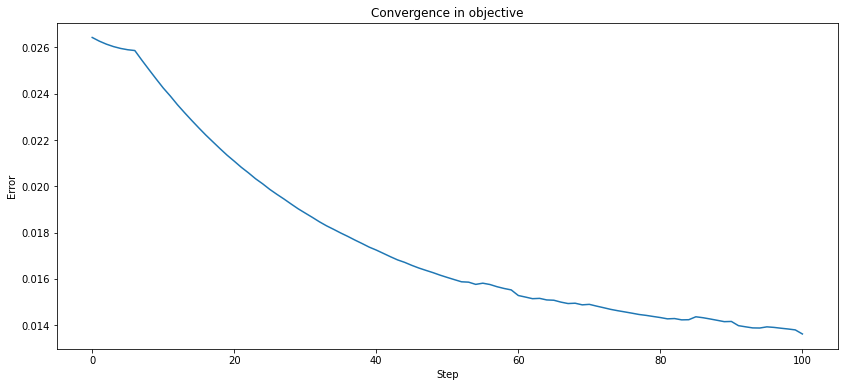

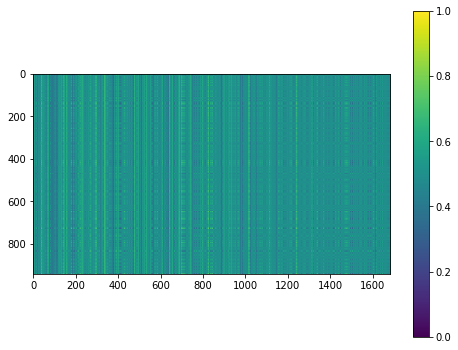

In [ ]:
convergence_plot([objective_function_robust(Y, O, X) for X in Xs_FZFW])
plot_matrix(Xs_FZFW[-1])

In [ ]:
nuclear_norm(Xs_FZFW[-1])

3.342102205563407

## FZCGS (Faster Zeroth-order Conditional Gradient Sliding)

From (GAO and HUANG, 2020)

In [ ]:
def FZCGS_LinSubProb(grad, delta):
  x, _, y = svds(-grad, k=1, which = "LM")
  return delta * x @ y


def CondG(g, u, gamma, eta, delta, xs):
  t = 1
  ut = np.copy(u)
  while (True):
    vt = FZCGS_LinSubProb((g + (ut-u) / gamma), delta)
    V_quy = np.sum((g + (ut-u) / gamma) * (ut - vt))
    if V_quy <= eta or t>10:
      return ut, xs
    alpha = np.sum(((u-ut)/gamma-g) * (vt-ut)) / ((np.linalg.norm(vt-ut, 'fro')**2)/gamma)
    alpha = alpha/3e3
    if alpha > 1:
      alpha = 1
    ut = (1-alpha)*ut + alpha*vt
    xs.append(ut)
    t = t+1

In [ ]:
def FZCGS(Y, O, constr, numiter = 40):
  """
  Faster Zeroth-order Conditional Gradient Sliding

  - Y: starting matrix
  - O: binary mask of observed values
  - constr: numerical value for the constraint on the nuclear norm
  - numiter: number of iterations
  """
  d0, d1 = Y.shape
  n = np.count_nonzero(Y)

  S1 = n
  q = S2 = int(np.sqrt(n))
  mu = 1/np.sqrt(d0*d1*numiter)
  # eta = 1/numiter
  L= np.max(Y)
  gamma = 1/(3e5*L)


  X0 = np.random.normal(0,1, (n0,n1)) # random initialization
  X0 = subproblem(X0,constr) # bring the initial iterate into the feasible set
  xs = [X0] # list that accumulates iterates
  grads = []
  for k in range(0,numiter):
    eta = 1 / (k**20+1)
    if (k % q == 0):
      S1_idxs = np.argwhere(Y!=0)
      grad = FZFW_gradient(xs[-1], mu, S1_idxs, Y)
      grads.append(grad)
    else:
      rng = np.random.default_rng()
      S2_idxs = rng.choice(S1_idxs, size=S2, replace=True)
      grad = FZFW_gradient(xs[-1], mu, S2_idxs, Y) - FZFW_gradient(xs[-2], mu, S2_idxs, Y) + grads[-1]
      grad = grad / S2
      grads.append(grad)
    x, xs = CondG(-grad, xs[-1], gamma, eta, constr,xs)
    xs.append(x)
  return xs

Let's run it.

In [ ]:
start_time = time.time()

Xs_FZCGS = FZCGS(Y, O, constr=5, numiter = 20)[:100]

time_FZCGS = time.time() - start_time
print("--- %s seconds ---" % (time_FZCGS))

--- 8.10271406173706 seconds ---


The nuclear norm of the resulting matrix.

In [ ]:
nuclear_norm(Xs_FZCGS[-1])

4.999659331683329

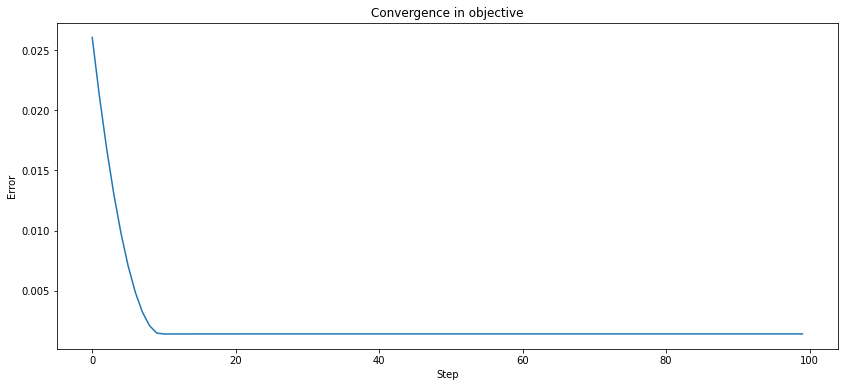

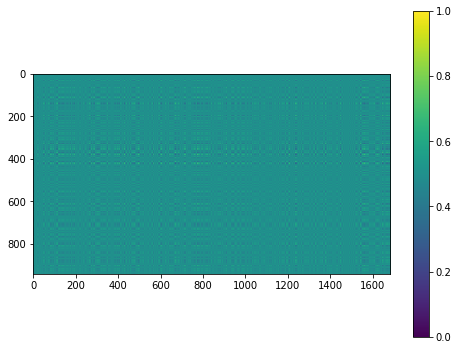

In [ ]:
convergence_plot([objective_function_robust(Y, O, X) for X in Xs_FZCGS])
plot_matrix(Xs_FZCGS[-1])

## Comparing results - Non Convex case

In [ ]:
fs_SGFFW_IRDSA_NC = [objective_function_robust(Y, O, X) for X in Xs_SGFFW_IRDSA_NC]
fs_FZFW = [objective_function_robust(Y, O, X) for X in Xs_FZFW]
fs_FZCGS = [objective_function_robust(Y, O, X) for X in Xs_FZCGS]

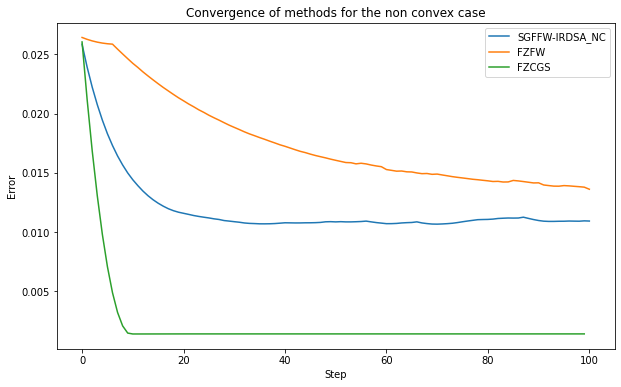

In [ ]:
plt.figure(figsize=(10,6))
plt.title('Convergence of methods for the non convex case')
plt.xlabel('Step')
plt.ylabel('Error')
# plt.yscale('log')
plt.plot(range(len(fs_SGFFW_IRDSA_NC)), fs_SGFFW_IRDSA_NC, label = "SGFFW-IRDSA_NC")
plt.plot(range(len(fs_FZFW)), fs_FZFW, label = "FZFW")
plt.plot(range(len(fs_FZCGS)), fs_FZCGS, label = "FZCGS")

plt.legend()